# Flame Temperature
This example demonstrates calculation of the adiabatic flame temperature for a methane/air mixture, comparing calculations which assume either complete or incomplete combustion.

In [1]:
%matplotlib inline
%config InlineBackend.figure_formats = ["svg"]
import cantera as ct
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams["figure.dpi"] = 120

print(f"Using Cantera version: {ct.__version__}")

Using Cantera version: 2.6.0a4


## Complete Combustion

The stoichiometric equation for complete combustion of a lean methane/air mixture ($\phi < 1$) is:

$$\mathrm{\phi CH_4 + 2(O_2 + 3.76 N_2) \rightarrow \phi CO_2 + 2\phi H_2O + 2 (1-\phi) O_2 + 7.52 N_2}$$

For a rich mixture ($\phi > 1$), this becomes:

$$\mathrm{\phi CH_4 + 2(O_2 + 3.76 N_2) \rightarrow CO_2 + 2 H_2O + (\phi - 1) CH_4 + 7.52 N_2}$$

To find the flame temperature resulting from these reactions using Cantera, we create a gas object containing only the species in the above stoichiometric equations, and then use the `equilibrate()` function to find the resulting mixture composition and temperature, taking advantage of the fact that equilibrium will strongly favor conversion of the fuel molecule.

In [2]:
# Get all of the Species objects defined in the GRI 3.0 mechanism
species = {S.name: S for S in ct.Species.listFromFile("gri30.yaml")}

# Create an IdealGas object with species representing complete combustion
complete_species = [species[S] for S in ("CH4", "O2", "N2", "CO2", "H2O")]
gas1 = ct.Solution(thermo="IdealGas", species=complete_species)

phi = np.linspace(0.5, 2.0, 100)
T_complete = np.zeros(phi.shape)
for i in range(len(phi)):
    gas1.TP = 300, ct.one_atm
    gas1.set_equivalence_ratio(phi[i], "CH4", "O2:1, N2:3.76")
    gas1.equilibrate("HP")
    T_complete[i] = gas1.T

## Incomplete Combustion

In the case of incomplete combustion, the resulting mixture composition is not known in advance, but must be found by calculating the equilibrium composition at constant enthalpy and temperature:

$$\mathrm{\phi CH_4 + 2(O_2 + 3.76 N_2) \rightarrow ? CO_2 + ? CO + ? H_2 + ? H_2O + ? O_2 + 7.52 N_2 + minor\ species}$$

Now, we use a gas phase object containing all 53 species defined in the GRI 3.0 mechanism, and compute the equilibrium composition as a function of equivalence ratio.

In [3]:
# Create an IdealGas object including incomplete combustion species
gas2 = ct.Solution(thermo="IdealGas", species=species.values())
T_incomplete = np.zeros(phi.shape)
for i in range(len(phi)):
    gas2.TP = 300, ct.one_atm
    gas2.set_equivalence_ratio(phi[i], "CH4", "O2:1, N2:3.76")
    gas2.equilibrate("HP")
    T_incomplete[i] = gas2.T

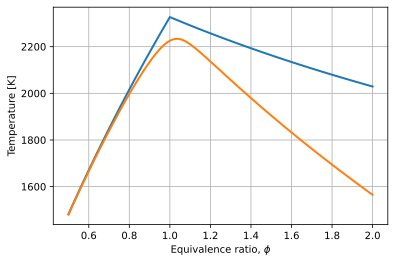

In [4]:
plt.plot(phi, T_complete, label="complete combustion", lw=2)
plt.plot(phi, T_incomplete, label="incomplete combustion", lw=2)
plt.grid(True)
plt.xlabel(r"Equivalence ratio, $\phi$")
plt.ylabel("Temperature [K]");